## DESI HIZ

In [15]:
import os
import numpy as np
import fitsio
from glob import glob
import matplotlib.pyplot as plt
from astropy.table import Table

import desispec.spectra
from desispec.io.spectra import read_spectra

from desigal.specutils.stack import stack_spectra
from fastspecfit.io import read_fastspecfit

from fastspecfit.util import TabulatedDESI
cosmo = TabulatedDESI()

from desiutil.log import get_logger
log = get_logger()

import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.2)

%matplotlib inline

In [16]:
desi_root = os.getenv('DESI_ROOT')

fspecdirs = {
    'odin': desi_root+'/users/raichoor/laelbg/odin/test/forjohn/v0/desi-odin.fits[SPECINFO]',
    'clauds': desi_root+'/users/raichoor/laelbg/clauds/test/forjohn/v0/desi-clauds.fits[SPECINFO]',
    'suprime': desi_root+'/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits[SPECINFO]',
    }

fphotodirs = {
    'odin': desi_root+'/users/raichoor/laelbg/odin/test/forjohn/v0/desi-odin.fits[PHOTINFO]',
    'clauds': desi_root+'/users/raichoor/laelbg/clauds/test/forjohn/v0/desi-clauds.fits[PHOTOFFINFO]',
    'suprime': desi_root+'/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits[PHOTINFO]',
    }

In [17]:
def parse_fphotodir(fphotodir):
    # parse the extension name, if any
    fphotoext = None
    photodir = os.path.dirname(fphotodir)
    photobase = os.path.basename(fphotodir)
    if '[' in photobase and ']' in photobase:
        try:
            fphotoext = photobase[photobase.find('[')+1:photobase.find(']')]
            fphotodir = os.path.join(photodir, photobase[:photobase.find('[')])
        except:
            pass
    return fphotodir, fphotoext

def read_desihiz(selection='odin', targetids=None, vi_redshifts=False):
    """Read Anand's desihiz catalogs."""
    
    fspecdir = fspecdirs[selection]
    fphotodir = fphotodirs[selection]

    fspecdir, fspecext = parse_fphotodir(fspecdir)
    fphotobasedir, fphotoext = parse_fphotodir(fphotodir)

    fphoto = Table(fitsio.read(fphotobasedir, ext=fphotoext))
    log.info(f'Read {len(fphoto):,d} objects from {fphotobasedir}')

    fspec = Table(fitsio.read(fspecdir, ext=fspecext))
    log.info(f'Read {len(fspec):,d} objects from {fspecdir}')
    assert(np.all(fspec['TARGETID'] == fphoto['TARGETID']))

    if targetids:
        I = np.where(np.isin(fspec['TARGETID'], np.array(','.split(targetids))))[0]
        log.info(f'Trimming to {len(I):,d} specified TARGETIDs.')
        fphoto = fphoto[I]
        fspec = fspec[I]

    if vi_redshifts:
        #I = np.where(np.isfinite(fspec['VI_Z']) * (fspec['VI_Z'] > 1e-3))[0]
        #log.info(f'Trimming to {len(I):,d} objects with VI_Z>0.001.')
        I = np.where(np.isfinite(fspec['VI_Z']) * (fspec['VI_Z'] > 1e-3) * (fspec['VI_QUALITY'] >= 3.))[0]
        log.info(f'Trimming to {len(I):,d} objects with VI_Z>0.001 and VI_QUALITY>=3.')
        fphoto = fphoto[I]
        fspec = fspec[I]

    return fphoto, fspec

In [35]:
fphoto, fspec = read_desihiz(selection='suprime')

INFO:2848552588.py:24:read_desihiz: Read 1,860 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits


2023-10-07 07:49:16,669 desiutil.log.dlm58.info INFO : Read 1,860 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits


INFO:2848552588.py:27:read_desihiz: Read 1,860 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits


2023-10-07 07:49:16,686 desiutil.log.dlm58.info INFO : Read 1,860 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/suprime/test/forjohn/v0/desi-suprime.fits


In [36]:
set(fspec['COADDFN'])

{'/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27245.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27247.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27250.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27256.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27257.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27258.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27259.fits',
 '/global/cfs/cdirs/desi/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416-v2/coadd-27344.fits'}

In [71]:
desi_root = os.getenv('DESI_ROOT')
datadir = desi_root+'/users/raichoor/laelbg/daily/healpix/tertiary26-thru20230416'
fastdir = desi_root+'/users/ioannis/tertiary/tertiary26'
figdir = os.getenv('HOME')+'/research/talks/2023/23jul18-laelbg'

In [22]:
fast, meta, _, _ = read_fastspecfit('/global/cfs/cdirs/desi/users/ioannis/desihiz/suprime/fastspec-vi-suprime.fits')
#meta

INFO:io.py:1848:read_fastspecfit: Read 1,020 object(s) from /global/cfs/cdirs/desi/users/ioannis/desihiz/suprime/fastspec-vi-suprime.fits


2023-10-07 07:44:08,284 desiutil.log.dlm58.info INFO : Read 1,020 object(s) from /global/cfs/cdirs/desi/users/ioannis/desihiz/suprime/fastspec-vi-suprime.fits


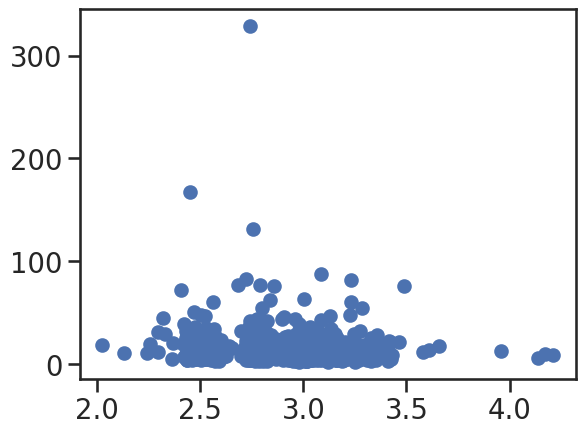

In [29]:
I = fast['LYALPHA_FLUX'] * np.sqrt(fast['LYALPHA_FLUX_IVAR']) > 2.
plt.scatter(fast['Z'][I], fast['LYALPHA_FLUX'][I])

In [122]:
nmfredrockfile = os.path.join(fastdir, 'redrock-nmf.fits')
if not os.path.isfile(nmfredrockfile):
    redrock = []
    for redfile in glob(os.path.join(fastdir, 'redrock-nmf-*.fits')):
        redrock.append(fitsio.read(redfile))
    redrock = Table(np.hstack(redrock))
    redrock.write(nmfredrockfile, overwrite=True)
    print('Wrote {} objects to {}'.format(len(redrock), nmfredrockfile))

Wrote 1093 objects to /Users/ioannis/work/desi/users/ioannis/tertiary/tertiary26/redrock-nmf.fits


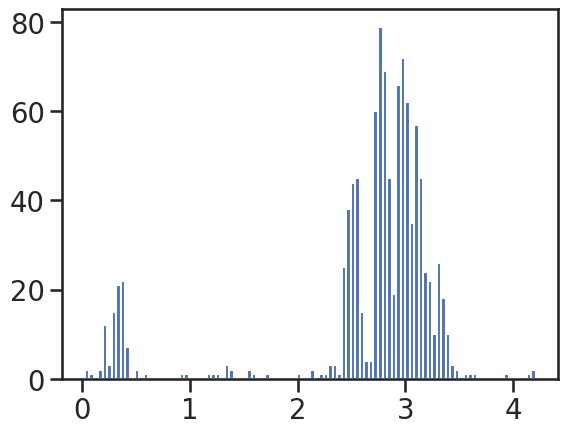

In [7]:
plt.hist(meta['Z'], bins=100);

In [123]:
merge = Table(fitsio.read(nmfredrockfile))
merge

TARGETID,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2
int64,float64,float64,int64,float64,float64[10],int64,str6,str20,int64,float64
39089837499745192,2.7937148902337703,0.0001367615362634,0,8767.372750341892,-0.27511388735849257 .. 0.023634787973606068,7930,GALAXY,,10,164.66928670927882
39089837499745205,4.320276519432837,0.0003123865961817679,4,8244.859581440687,-0.21845013254918422 .. -0.06611500536423984,7929,GALAXY,,10,2.700770825147629
39089837499745276,2.847650179079079,9.713163086192271e-05,0,8442.14040362835,-0.1275865366382729 .. 0.02902147327397521,7929,GALAXY,,10,531.8870344981551
39089837499745193,2.587885641640421,0.00017348099926104386,4,8216.226537644863,-0.09417362888250466 .. 0.11978155336528717,7929,GALAXY,,10,2.284302009269595
39089837499745180,1.5458294321978627,0.0001068608008317952,4,9279.067999571562,0.26500098761578866 .. 0.093016999649723,7929,GALAXY,,10,3.7984388172626495
39089837499745204,2.7414195192852193,9.639562815352173e-05,0,8678.884593367577,0.020295930722455228 .. 0.04078956781441609,7929,GALAXY,,10,245.26391446217895
39089837499745185,0.2145524183302662,6.578742562002948e-06,0,9756.880612015724,-1.2636424350822117 .. 0.04617919335900168,7930,GALAXY,,10,1301.8456109762192
...,...,...,...,...,...,...,...,...,...,...
39089837499744849,0.38971174432256334,2.037979926325697e-05,0,8747.15604943037,0.28947359170406767 .. 0.07289679980264617,7929,GALAXY,,10,201.58635741472244


In [146]:
vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
vi = Table(fitsio.read(vifile))
vi[(vi['VI_Z'] == 0.0) * (vi['VI_QUALITY'] >= 3)]

VI_TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499745035,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,3.2468,259.4,dey,4,,0.0,QSO,LAE; NL AGN; Lya CIV CIII],150.44293160258158,1.5627406598357527,SUPRIME,8500


VI - LAE 520 340 65.38461538461539
VI - LBG 53 6 11.320754716981131
VI - QSO 25 18 72.0


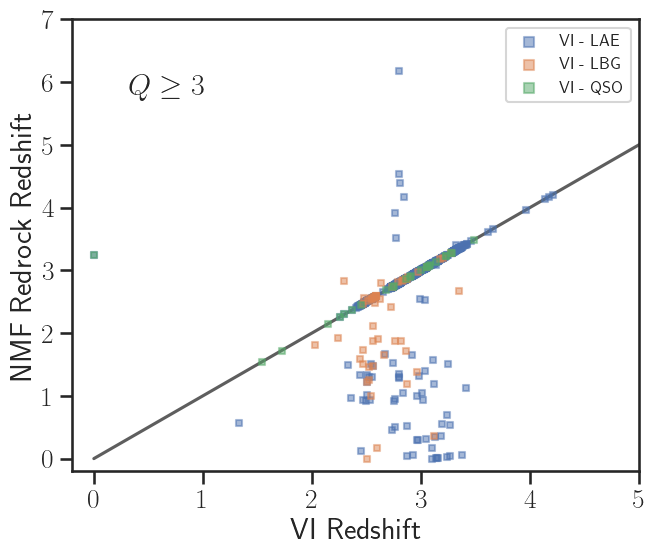

In [148]:
def zvi_vs_zredrock_nmf():
    """Compare NMF Redrock and VI redshifts."""
    merge = Table(fitsio.read(nmfredrockfile))

    vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
    vi = Table(fitsio.read(vifile))
    vi.rename_column('VI_TARGETID', 'TARGETID')
    #print(vi.colnames)
    
    #I = np.hstack([np.where(vi['TARGETID'] == tid)[0] for tid in merge['TARGETID']])
    #vi = vi[I]
    #assert(np.all(merge['TARGETID'] == vi['TARGETID']))
    I = np.hstack([np.where(merge['TARGETID'] == tid)[0] for tid in vi['TARGETID']])
    merge = merge[I]
    assert(np.all(merge['TARGETID'] == vi['TARGETID']))
    
    iqso = np.where((vi['VI_QUALITY'] >= 3) * np.array(['qso' in comment.lower() or 'agn' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    ilae = np.where((vi['VI_QUALITY'] >= 3) * np.array(['lae' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    ilbg = np.where((vi['VI_QUALITY'] >= 3) * np.array(['lbg' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    
    fig, ax = plt.subplots(figsize=(7, 6))
    if False:
        for qual in sorted(set(vi['VI_QUALITY'])):
            if qual < 2:
                continue
            I = qual == vi['VI_QUALITY']
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=30, marker='s', #color='orange', 
                       alpha=0.5, label=f'Q={qual}')
    elif False:
        for spectype in sorted(set(vi['REDROCK_SPECTYPE'])):
            I = (spectype == vi['REDROCK_SPECTYPE']) * (vi['VI_QUALITY'] > 3)
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=15, marker='s', #color='orange', 
                       alpha=0.5, label=spectype)
    else:
        for I, label in zip([ilae, ilbg, iqso], ['VI - LAE', 'VI - LBG', 'VI - QSO']):
            N = np.sum(np.abs(vi['VI_Z'][I]-merge['Z'][I]) < 1e-3)
            print(label, len(I), N, 100*N/len(I))
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=15, marker='s', #color='orange', 
                       alpha=0.5, label=label)
        
    ax.legend(loc='upper right', fontsize=12, markerscale=2)#ncols=2)
    ax.set_xlim(-0.2, 5)
    ax.set_ylim(-0.2, 7)
    ax.plot([0, 7], [0, 7], color='k', alpha=0.7, zorder=-1)
    plt.rcParams['text.usetex'] = True    
    ax.text(0.1, 0.85, '$Q \ge 3$', ha='left', va='center', transform=ax.transAxes)
    ax.set_xlabel('VI Redshift')
    ax.set_ylabel('NMF Redrock Redshift')

    fig.tight_layout()
    fig.savefig(figdir+'/zvi-vs-zredrock-nmf.png')
    
    #plt.clf()
    #plt.hist(vi['VI_Z'] - merge['Z'], bins=100)
    
    return vi

zvi = zvi_vs_zredrock_nmf()

VI - LAE 520 23 4.423076923076923
VI - LBG 53 1 1.8867924528301887
VI - QSO 25 21 84.0


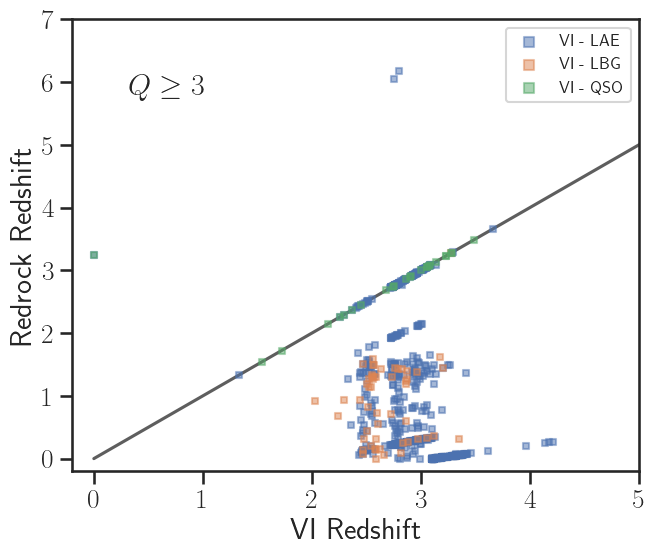

In [149]:
def zvi_vs_zredrock():
    """Compare Redrock and VI redshifts."""
    mergefile = os.path.join(datadir, 'merge-tertiary26-thru20230416.fits')
    merge = Table(fitsio.read(mergefile))

    vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
    vi = Table(fitsio.read(vifile))
    vi.rename_column('VI_TARGETID', 'TARGETID')
    #print(vi.colnames)
    
    I = np.hstack([np.where(merge['TARGETID'] == tid)[0] for tid in vi['TARGETID']])
    merge = merge[I]
    assert(np.all(merge['TARGETID'] == vi['TARGETID']))
    
    iqso = np.where((vi['VI_QUALITY'] >= 3) * np.array(['qso' in comment.lower() or 'agn' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    ilae = np.where((vi['VI_QUALITY'] >= 3) * np.array(['lae' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    ilbg = np.where((vi['VI_QUALITY'] >= 3) * np.array(['lbg' in comment.lower() for comment in vi['VI_COMMENT']]))[0]
    
    fig, ax = plt.subplots(figsize=(7, 6))
    if False:
        for qual in sorted(set(vi['VI_QUALITY'])):
            if qual < 2:
                continue
            I = qual == vi['VI_QUALITY']
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=30, marker='s', #color='orange', 
                       alpha=0.5, label=f'Q={qual}')
    elif False:
        for spectype in sorted(set(vi['REDROCK_SPECTYPE'])):
            I = (spectype == vi['REDROCK_SPECTYPE']) * (vi['VI_QUALITY'] > 3)
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=15, marker='s', #color='orange', 
                       alpha=0.5, label=spectype)
    else:
        for I, label in zip([ilae, ilbg, iqso], ['VI - LAE', 'VI - LBG', 'VI - QSO']):
            N = np.sum(np.abs(vi['VI_Z'][I]-merge['Z'][I]) < 1e-3)
            print(label, len(I), N, 100*N/len(I))
            ax.scatter(vi['VI_Z'][I], merge['Z'][I], s=15, marker='s', #color='orange', 
                       alpha=0.5, label=label)
        
    ax.legend(loc='upper right', fontsize=12, markerscale=2)#ncols=2)
    ax.set_xlim(-0.2, 5)
    ax.set_ylim(-0.2, 7)
    ax.plot([0, 7], [0, 7], color='k', alpha=0.7, zorder=-1)
    plt.rcParams['text.usetex'] = True    
    ax.text(0.1, 0.85, '$Q \ge 3$', ha='left', va='center', transform=ax.transAxes)
    ax.set_xlabel('VI Redshift')
    ax.set_ylabel('Redrock Redshift')

    fig.tight_layout()
    fig.savefig(figdir+'/zvi-vs-zredrock.png')
    
    return vi

zvi = zvi_vs_zredrock()

##### 

In [93]:
zvi[zvi['TARGETID'] == 39089837499746048]

TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499746048,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.3131,17.1,dey,4,,3.0286,GALAXY,LAE,149.8656626408202,1.530407590501443,LAE_SUBARU,8000


In [31]:
def read_data():
    mergefile = os.path.join(fastdir, 'fastspec-vi-tertiary26.fits')
    fast, meta, _, _ = read_fastspecfit(mergefile)

    vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
    vi = Table(fitsio.read(vifile))
    #iqso = ['qso' in comment.lower() or 'agn' in comment.lower() for comment in vi['VI_COMMENT']]
    #I = np.logical_not(iqso) * (vi['VI_QUALITY'] >=3) * (vi['VI_Z'] > 2.4) * (vi['VI_Z'] < 3.5)
    #vi = vi[I]
    vi.rename_column('VI_TARGETID', 'TARGETID')
    
    # trim out the LBGs
    #ilae = np.where(['lae' in comment.lower() for comment in vi['VI_COMMENT']])[0]
    #vi = vi[ilae]
    
    I = np.hstack([np.where(vi['TARGETID'] == tid)[0] for tid in fast['TARGETID']])
    vi = vi[I]
    #I = np.hstack([np.where(fast['TARGETID'] == tid)[0] for tid in vi['TARGETID']])
    #fast = fast[I]
    #meta = meta[I]
    
    fast['LYALPHA_LUM'] = fast['LYALPHA_FLUX'] * 1e-17 * 4 * np.pi * (cosmo.luminosity_distance(fast['Z']) * 3.0856776e+24)**2
    
    return vi, meta, fast

vi, meta, fast = read_data()
vi

INFO:io.py:1774:read_fastspecfit: Read 264 object(s) from /Users/ioannis/work/desi/users/ioannis/tertiary/tertiary26/fastspec-vi-tertiary26.fits


2023-07-17 15:05:12,290 desiutil.log.dlm58.info INFO : Read 264 object(s) from /Users/ioannis/work/desi/users/ioannis/tertiary/tertiary26/fastspec-vi-tertiary26.fits


TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499745281,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.424,56.8,dey,4,,2.4205,GALAXY,LAE; double peaked line; z from CIII],150.36887612015116,1.736169244923023,LAE_SUBARU,8000
39089837499745283,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.2927,1.0,dey,4,,2.4454,GALAXY,LAE,149.4702598586282,1.6076629936276436,LAE_SUBARU,8000
39089837499745286,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.4135,37.9,dey,4,,2.4166,GALAXY,LAE,149.82763488365626,1.6472517347095443,LAE_SUBARU,8000
39089837499745287,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.0896,1.2,dey,4,,2.4507,GALAXY,LAE,149.8669898121445,1.6774942523808365,LAE_SUBARU,8000
39089837499745292,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.4076,385.7,dey,4,,2.4076,GALAXY,LAE,150.561448291361,2.0059238084332245,LAE_SUBARU,8000
39089837499745293,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.368,0.8,dey,4,,2.4478,GALAXY,LAE,150.17442732633376,1.5331197462767607,LAE_SUBARU,8000
39089837499745294,0,0.57.0.dev7802,0.17.0.dev758,-1,QSO,2.4304,114.5,dey,4,,2.4304,GALAXY,LAE; Lya + CIV,150.20894950165467,1.5268020404236438,LAE_SUBARU,8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39089837499746453,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.3295,18.0,dey,4,,3.0782,GALAXY,LAE,150.47751087087443,2.6257242453193,LAE_SUBARU,8000


In [97]:
print(set(meta['HEALPIX']))
meta[meta['HEALPIX'] == 27245]['TARGETID'].data

{27245, 27247, 27344, 27256, 27258, 27259}


array([39089837499745286, 39089837499745287, 39089837499745334,
       39089837499745338, 39089837499745386, 39089837499745428,
       39089837499745556, 39089837499745657, 39089837499745658,
       39089837499745659, 39089837499745662, 39089837499745665,
       39089837499745668, 39089837499745669, 39089837499745675,
       39089837499745733, 39089837499745738, 39089837499745740,
       39089837499745742, 39089837499745843, 39089837499745844,
       39089837499745845, 39089837499745949, 39089837499745998,
       39089837499745999, 39089837499746001, 39089837499746002,
       39089837499746008, 39089837499746045, 39089837499746046,
       39089837499746047, 39089837499746048, 39089837499746049,
       39089837499746168, 39089837499746169, 39089837499746179,
       39089837499746232, 39089837499746233, 39089837499746234,
       39089837499746352, 39089837499746354, 39089837499746355])

In [100]:
meta[np.isin(meta['TARGETID'], [39089837499746048, 39089837499745286])]['TARGETID', 'Z']

TARGETID,Z
int64,float64
39089837499745286,2.4166
39089837499746048,3.0286


In [7]:
meta['Z'].min()

2.4076

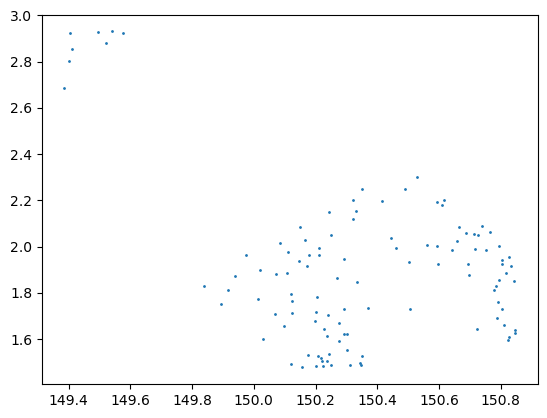

In [8]:
plt.scatter(meta['RA'], meta['DEC'], s=1)

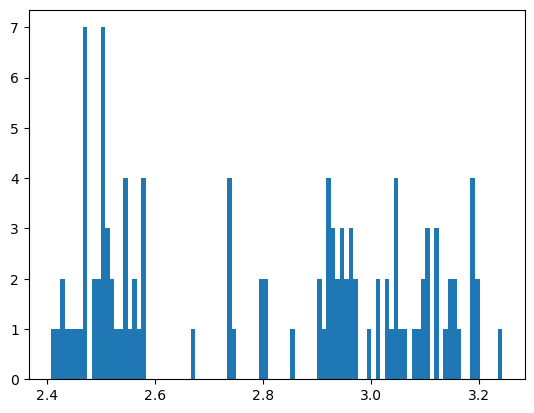

In [9]:
_ = plt.hist(meta['Z'], bins=100)

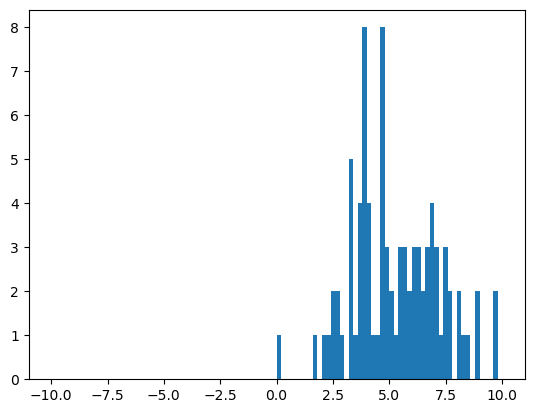

In [10]:
_ = plt.hist(fast['LYALPHA_FLUX'], bins=100, range=(-10, 10))
#plt.xlim(-100, 1000)

In [11]:
I = ['LBG' in comment for comment in vi['VI_COMMENT']]
vi[I]

TARGETID,TILEID,SPEC_VERSION,REDROCK_VERSION,TEMPLATE_VERSION,REDROCK_SPECTYPE,REDROCK_Z,REDROCK_DELTACHI2,VI_SCANNER,VI_QUALITY,VI_ISSUE,VI_Z,VI_SPECTYPE,VI_COMMENT,RA,DEC,TERTIARY_TARGET,PRIORITY
int64,int32,str14,str13,str12,str6,float64,float64,str3,int16,str1,float64,str6,str120,float64,float64,str11,int16
39089837499744861,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.4502,13.9,dey,4,,3.2032,GALAXY,LAE; LBG; z from Lya,149.8241467966105,1.5839302040469807,SUPRIME,8500
39089837499744723,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.2973,2.9,dey,3,,2.732,GALAXY,LAE LBG; double-peaked line; z from abspn,149.70764094357395,1.5610287904944338,SUPRIME,8500
39089837499744730,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,1.499,10.6,dey,4,,2.5643,GALAXY,LAE LBG,149.5279732708069,1.7752624817138511,SUPRIME,8500
39089837499744969,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.4472,2.7,dey,3,,2.51,GALAXY,LAE LBG,150.06064896917894,1.8717592879316078,SUPRIME,8500
39089837499744745,0,0.57.0.dev7802,0.17.0.dev758,-1,GALAXY,0.2523,35.8,dey,4,,2.8402,GALAXY,LAE LBG,149.69456464282413,1.855624563589278,SUPRIME,8500


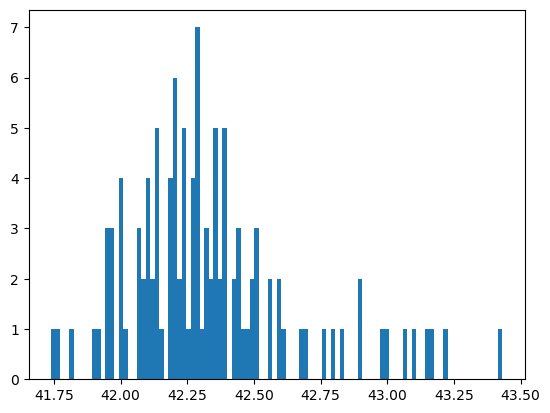

In [12]:
I = fast['LYALPHA_LUM'] > 0
_ = plt.hist(np.log10(fast['LYALPHA_LUM'][I]), bins=100)

In [15]:
#vi[fast['LYALPHA_FLUX'] < 0]['TARGETID', 'VI_COMMENT']

In [16]:
fast[fast['LYALPHA_FLUX'] == 0.]['HEALPIX', 'TARGETID', 'LYALPHA_FLUX', 'LYALPHA_EW']

HEALPIX,TARGETID,LYALPHA_FLUX,LYALPHA_EW
int32,int64,float32,float32
27256,39089837499746289,0.0,0.0


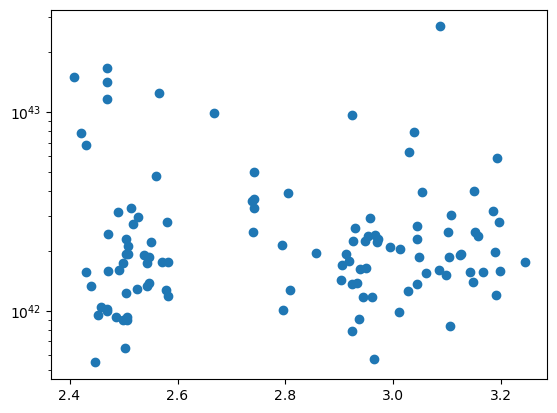

In [17]:
plt.scatter(fast['Z'], fast['LYALPHA_LUM'])
plt.yscale('log')
#plt.ylim(-100, 500)

In [18]:
minmax = np.array([3600, 9800, 0.8]) 
minmax / (1 + meta['Z'].min()), minmax / (1+meta['Z'].max())
minmax / (1 + 2.4), minmax / (1+3.5)

(array([1.05882353e+03, 2.88235294e+03, 2.35294118e-01]),
 array([8.00000000e+02, 2.17777778e+03, 1.77777778e-01]))

In [19]:
minwave, maxwave, dwave = 920., 2500., 0.05
gridwave = np.arange(minwave, maxwave+dwave, dwave)
gridwave

array([ 920.  ,  920.05,  920.1 , ..., 2499.95, 2500.  , 2500.05])

Stack everything

In [20]:
allspec = []
for healpix in sorted(set(meta['HEALPIX'])):
    mm = meta[meta['HEALPIX'] == healpix]    
    specfile = os.path.join(datadir, f'coadd-{healpix}.fits')
    spec = read_spectra(specfile).select(targets=mm['TARGETID'])
    allspec.append(spec)
allspec = desispec.spectra.stack(allspec)

INFO:spectra.py:291:read_spectra: iotime 0.683 sec to read coadd-27256.fits at 2023-07-16T14:38:24.467546


2023-07-16 14:38:24,467 desiutil.log.dlm58.info INFO : iotime 0.683 sec to read coadd-27256.fits at 2023-07-16T14:38:24.467546


INFO:spectra.py:291:read_spectra: iotime 0.762 sec to read coadd-27344.fits at 2023-07-16T14:38:25.863265


2023-07-16 14:38:25,863 desiutil.log.dlm58.info INFO : iotime 0.762 sec to read coadd-27344.fits at 2023-07-16T14:38:25.863265


In [21]:
srt = np.hstack([np.where(meta['TARGETID'] == tid)[0] for tid in allspec.fibermap['TARGETID']])
fast = fast[srt]
meta = meta[srt]
assert(np.all(meta['TARGETID'] == allspec.fibermap['TARGETID']))

In [22]:
(flux, ivar), wave = stack_spectra(allspec, redshift=meta['Z'], norm_method='flux-window', #"mean", "median", "flux-window"
                                   norm_flux_window=[1500, 1550], output_wave_grid=gridwave,
                                   resample_method='linear', # "linear", "sn-cons", "flux-cons"
                                   stack_method='ivar-weighted-mean', # median , mean
                                   n_workers=24, bootstrap=True)

/opt/homebrew/Caskroom/miniforge/base/envs/fastspecfit/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


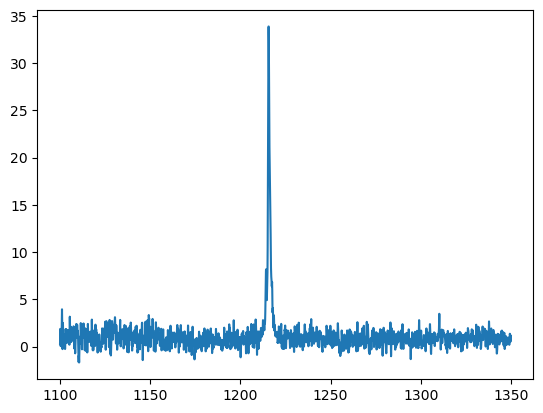

In [23]:
I = (wave > 1100) * (wave < 1350)
plt.plot(wave[I], flux[I])

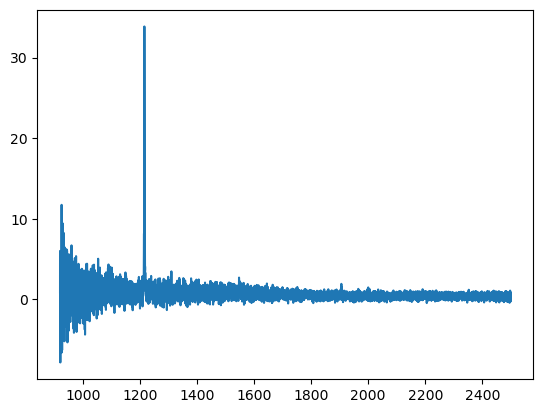

In [24]:
plt.plot(wave, flux)